In [1]:
import import_ipynb
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
from torch.autograd import Variable
import time
from tqdm import tqdm
import random


In [2]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False
n_classes = 120
n_inputs = model.fc.in_features
# n_inputs will be 4096 for this case
# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

In [3]:
all_data = datasets.ImageFolder(root='data')
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()}

In [4]:
torch.cuda.is_available()

True

In [5]:
chkpt_name = "model.chkpt"

model.load_state_dict(torch.load(chkpt_name))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
def predict(img):
    
    plt.figure(figsize=(20, 20))
    plt.subplot(331)
    img = plt.imread(img)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.imshow(img) 
    
    transform = transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = transforms.ToPILImage()(img)
    img = transform(img)
    img = img.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, dim=1)
        
        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function  
        out = torch.exp(output)
        top_p, top_class = out.topk(2, dim=1)
        
        highest = top_p[0][0].item()
        second = top_p[0][1].item()
        total = highest + second
        first_term =  highest / total * 100
        second_term = second /total * 100
  
        breed1 = model.idx_to_class[top_class[0][0].item()]
        breed2 = model.idx_to_class[top_class[0][1].item()]
        
        c = breed1.split('_')
        c = " ".join(c).split('-')
        
        #breed = model.idx_to_class[pred[0].item()]
        dog = np.random.choice(os.listdir('Annotation/' + breed1))
        img = 'Images/' + breed1 + '/' + dog + '.jpg'
        show = plt.imread(img)
        plt.subplot(332)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        if top_p[0][0] < 0.7:
            a = "%.2f" % first_term + '%'
            plt.title(c[1] + " " + a )
        else:
            plt.title(c[1])
        plt.imshow(show)  
        
        d = breed2.split('_')
        d = " ".join(d).split('-')
        
        if top_p[0][0] < 0.7:
            
            dog = np.random.choice(os.listdir('Annotation/' + breed2))
            img = 'Images/' + breed2 + '/' + dog + '.jpg'
            show = plt.imread(img)
            plt.subplot(333)
            plt.gca().axes.get_yaxis().set_visible(False)
            plt.gca().axes.get_xaxis().set_visible(False)
            b = "%.2f" % second_term + '%'
            plt.title(d[1] + " " + b )
            plt.imshow(show)  
            return c[1], d[1], a, b
        else:
            return c[1]

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()

In [8]:
df = pd.DataFrame(columns=['User', 'Dog'])
df = df.append({'User': 'Hi', 'Dog':'Wof wof!'}, ignore_index=True)
df = df.append({'User': 'fsd'}, ignore_index=True)
df = df.replace(np.nan, "wof wof")
df.head()

,User,Dog
0,Hi,Wof wof!
1,fsd,wof wof


In [9]:
#df = pd.DataFrame(columns=['User', 'Dog'])
df = df.append({'User': 'Hi', 'Dog':'Wof wof!'}, ignore_index=True)
df = df.append({'User': 'How old are you', 'Dog':'I am 4, in human years I am 30, and you?'}, ignore_index=True)
df = df.append({'User': 'I am 24', 'Dog':'Cool!'}, ignore_index=True)
df = df.append({'User': 'Do you like sausage', 'Dog':'I LOVE them! Do you have some of them for me?'}, ignore_index=True)
df = df.append({'User': 'Not now', 'Dog': ":( I want to go for a walk!"}, ignore_index=True)
df = df.append({'User': 'Not now', 'Dog':'So when?'}, ignore_index=True)
df = df.append({'User': 'Tomorrow', 'Dog':"Tomorrow is sooo late. Maybe it's better if I go to sleep"}, ignore_index=True)
df = df.append({'User': 'play', 'Dog':'Yes I want to play with the ball'}, ignore_index=True)
df = df.append({'User': "What's your name?", 'Dog':"My name is Paros, it's the name of a Greek island, I was found there."}, ignore_index=True)
df = df.append({'User': 'Oh wow! you are Greek?', 'Dog':'I am a cutie greek dog!'}, ignore_index=True)
df = df.append({'User': 'Where are you from?', 'Dog':'I come from a beautiful island in Greece, called Paros'}, ignore_index=True)
df = df.append({'User': 'Is your family there?', 'Dog':'My family is in Greece, I live with you now. Give me some sausages!'}, ignore_index=True)
df = df.append({'User': 'What do you like?', 'Dog':'I LOVE sausages! And you?'}, ignore_index=True)
df = df.append({'User': 'I like', 'Dog':"This is very nice. Did you know that dogs have sense of time? That's why I complain when you promise me to go out in one hour and you then you are still watching lame TV shows"}, ignore_index=True)
df = df.append({'User': 'Really?', 'Dog':'Oh yes!'}, ignore_index=True)
df = df.append({'User': 'I am sorry', 'Dog':'No worries, I will always love you'}, ignore_index=True)
df = df.append({'User': 'What else?', 'Dog':'I become jealous when you give attentions to the cat. Oh God knows I hate cats!'}, ignore_index=True)
df = df.append({'User': "How are you?", 'Dog': "I feel blue, I saw a pretty cocker spaniel but she didn't let me smell her ass"}, ignore_index=True)
df = df.append({'User': "How are you?", 'Dog': "I feel great, it's game time!"}, ignore_index=True)
df = df.append({'User': "No it's not", 'Dog': "Wof wof, me sad"}, ignore_index=True)
df = df.append({'User': "Why are you sad?", 'Dog': "You don't give me enough attention"}, ignore_index=True)
df = df.append({'User': "How are you?", 'Dog': "Wofffffffff I would be the happiest if you could take me for a walk!"}, ignore_index=True)
df = df.append({'User': "Ok let's go!", 'Dog': "Yeahhhh"}, ignore_index=True)
df = df.append({'User': "Where do you want to go?", 'Dog': "To the park! All my friends are there"}, ignore_index=True)
df = df.append({'User': "Who are your friends?", 'Dog': "There is Beethoven, Laila and Snoopy"}, ignore_index=True)
df = df.append({'User': "Snoopy", 'Dog': "Yes he's my friend!"}, ignore_index=True)
df = df.append({'User': "Beethoven", 'Dog': "I love him!"}, ignore_index=True)
df = df.append({'User': "What kind of dog is that?", 'Dog': "Upload a picture!"}, ignore_index=True)



In [10]:
df.dropna(inplace=True)

In [11]:
df = pd.read_csv('dog_dataframe.csv')

In [12]:
vectorizer.fit(np.concatenate((df.User, df.Dog)))
Question_vectors = vectorizer.transform(df.User)

In [13]:
df.head()

,User,Dog
0,Hi,Wof wof!
1,How old are you,"I am 4, in human years I am 30, and you?"
2,I am 24,Cool!
3,Do you like sausage,I LOVE them! Do you have some of them for me?
4,Not now,:( I want to go for a walk!


DOG: Bau bau!

YOU: what kind of dog is that?
DOG: Upload a picture!
YOU: paros.jpg
DOG: This looks to me like a crossbreed between a cocker spaniel (65.83%) and a Siberian husky (34.17%)


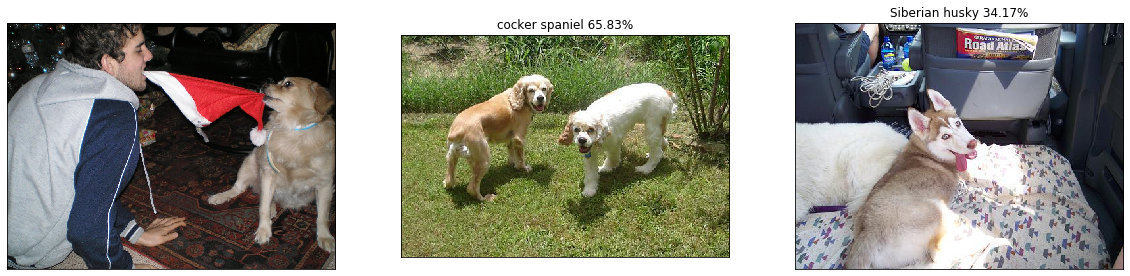

In [20]:
status = True
print("DOG: Bau bau!")
print("")
while status == True:
    digit = False
    df = pd.read_csv('dog_dataframe.csv')
    df.dropna(inplace=True)
    # Read user input
    human = input('YOU: ').lower()
    vectorizer.fit(np.concatenate((df.User, df.Dog)))
    Question_vectors = vectorizer.transform(df.User)
    
    if human == 'bye':
        print("DOG: Wof see you soon!")
        break
    # Locate the closest question
    input_question_vector = vectorizer.transform([human])
    
    # Compute similarities
    similarities = cosine_similarity(input_question_vector, Question_vectors)
    
    #Check if the question already exists in the df, if it doesn't it appends the new question and assign randomly
    # an asnwer
    sort = sorted(similarities[0], reverse = True)
    if sort[0] != 1:
        df = df.append({'User': human}, ignore_index=True)
        
        questions = ["Do you know you can lower your body pressure by petting me?",
        "You know that the reason why I curl up when I sleep is because I want to protect my vital organs?",
        "Do you know I have wet nose because it helps me to absorb scent!?", 
        "You should leave me a piece of clothing that smells like you, the scent will help my separation anxiety",
        "You know the basenji is the only breed of dog that can't bark? but they can yodel!",
        "You know if you pet me and gaze into my eyes I release oxytocin, and you as well? So pet me :)",
        "Sorry to interrupt you, you know the Saluki is the world’s oldest dog breed? They appear in ancient Egyptian tombs dating back to 2100 B.C.",
        "Yes yes..anyways I never told you: Thank you for having me spayed, I will live longer now",
        "Hey! You know my sense of smell is approximately 100,000 times better than yours? I can smell your feelings",
        "My best friend! You know I can be trained to detect cancer and other diseases in humans? WOF!"]
        
        q = random.choice(questions)
        df = df.replace(np.nan, q)
        export_csv = df.to_csv ('dog_dataframe.csv', index = None, header=True) 
    
    #vectorize the questions
    vectorizer.fit(np.concatenate((df.User, df.Dog)))
    Question_vectors = vectorizer.transform(df.User)
    #define the closest question in comparison to the input
    closest = np.argmax(similarities, axis=1) 
    
    # check if there is a digit: if so, the answer will be: Cool
    hum = human.lower().split()
    for t in hum:
        if t.isdigit():
            digit = True
            
    if digit == False:
        # We give some variability in the answers, if the question is similat to How are You? then the
        # system picks randomly between 4 possible answers
        if df.User.iloc[closest].values[0] == 'How are you?':
            a = ["DOG: Wofffffffff I would be the happiest if you could take me for a walk!", 
            "DOG: I am good!","DOG: " + df.Dog.iloc[closest].values[0], "DOG: There's a cat in the garden who annoys me", 
                "DOG: The mailman just arrived, let's go catch him!"]
            print(random.choice(a))
            print("")
        # question to call the predict method
        elif df.User.iloc[closest].values[0] == 'What kind of dog is that?':
            try:
                a = ["DOG: " + df.Dog.iloc[closest].values[0]]
                print(random.choice(a))
                picture = input('YOU: ')

                try:
                    a, b,c, d= predict(picture)
                    print("DOG: This looks to me like a crossbreed between a {} ({}) and a {} ({})".format(a,c,b,d))
                    status = False
                except:
                    print("DOG: This looks like a {} to me".format(predict(picture)))
                    status = False
            except:
                a = ["DOG: Wofffffffff I would be the happiest if you could take me for a walk!", 
            "DOG: I am good!","DOG: " + df.Dog.iloc[closest].values[0], "DOG: There's a cat in the garden who annoys me", 
                "DOG: The mailman just arrived, let's go catch him!"]
                print(random.choice(a))
                print("")
        
        # answer with the response correspondant to the highest question matched
        else:
            print("DOG: " + df.Dog.iloc[closest].values[0])
            print("")
    else:
        print('DOG: Cool!')
        print("")
    
export_csv = df.to_csv ('dog_dataframe.csv', index = None, header=True) 
status = True